<a href="https://colab.research.google.com/github/Will170393/MSc-Project---Stance-Detection/blob/master/2_msc_project_glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# libraries for processing data
import numpy as np
import pandas as pd
import re

# libraries for loading files from drive
from google.colab import drive
drive.mount('/content/gdrive')

# libraries for natural language processing
from nltk import FreqDist, word_tokenize
import nltk
nltk.download('punkt')

from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score

# neural network libraries
import tensorflow as tf
from keras import regularizers
from keras.layers import Dense
from keras.models import Model, Sequential
from keras.layers import Dropout, Activation
from keras.utils.np_utils import to_categorical

from matplotlib import pyplot as plt

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Reading data into panda dataframes and merging Stances and Bodies**

In [0]:
# creates dataframes from reading the stance and body csv files from the google drive, train/test set already split
trainStances = pd.read_csv('gdrive/My Drive/Colab Notebooks/MSC_project_data/train_stances.csv')
trainBodies = pd.read_csv('gdrive/My Drive/Colab Notebooks/MSC_project_data/train_bodies.csv')
testStances = pd.read_csv('gdrive/My Drive/Colab Notebooks/MSC_project_data/competition_test_stances.csv')
testBodies = pd.read_csv('gdrive/My Drive/Colab Notebooks/MSC_project_data/competition_test_bodies.csv')

In [0]:
# merges dataframes for article bodies and article stances, inner merge on the Body ID column that appears in both dataframes
def mergeStances_Bodies(stances, bodies):
  return pd.merge(stances, bodies, how='inner', on='Body ID')

In [0]:
# creates merged training and test dataframes
train = mergeStances_Bodies(trainStances, trainBodies)
test = mergeStances_Bodies(testStances, testBodies)

**Data Cleaning**

In [0]:
#removes non-alphabetic characters from strings and make all characters lower case
def data_cleaning(data, col):
  p = re.compile(r'[^\w\s]+')
  data[col] = [p.sub('', str(string)) for string in data[col].tolist()] #uses regex to substitute all non_alphabtic characters with whitespace
  data[col] = [[character.lower() for character in word_tokenize(string)] for string in data[col]] #tokenizes the words and converts characters to lower case
  data[col] = [' '.join(word) for word in data[col]]        

In [0]:
# cleaning dataframes for article Headlines and Bodies
data_cleaning(train, 'Headline')
data_cleaning(train, 'articleBody')
data_cleaning(test, 'Headline')
data_cleaning(test, 'articleBody')

In [0]:
#Load pre-defined stops words file from google drive into a list
f = open('gdrive/My Drive/Colab Notebooks/MSC_project_data/project_stopwords_final.txt', encoding='utf-8-sig')
stop_words = f.read().split('\n')
f.close

<function TextIOWrapper.close>

In [0]:
#removing stop words from training and test set
def remove_stop_words(data, col, stop_words):
  filtered_sentence = data[col].apply(lambda text: [word for word in text.split() if word not in stop_words]) #all all tokens not in stop words list to filtered_tokens
  data[col] = [' '.join(word) for word in filtered_sentence]                                         

In [0]:
# removing stopwords in dataframes for article Headlines and Bodies
remove_stop_words(train, 'Headline', stop_words)
remove_stop_words(train, 'articleBody', stop_words)
remove_stop_words(test, 'Headline', stop_words)
remove_stop_words(test, 'articleBody', stop_words)

**Shuffling and sampling data**

In [0]:
# methods for re-sampling from dataframe
from sklearn.utils import resample

def upsample_data(dataframe, classification, target_samples):
  classification = str(classification)
  minority_class = dataframe[dataframe.Stance == classification]
  samples = len(minority_class)
  
  samples_left = (target_samples - samples)
  
  while (samples_left != 0):
    
    if(samples_left < samples):
      samples = samples_left
  
    minority_class_upsampled = resample(minority_class,
                                        replace = False,
                                        n_samples = samples)
  
    dataframe = dataframe.append(minority_class_upsampled, ignore_index=True)
    
    samples_left -= samples
  
  dataframe = dataframe.sample(frac=1).reset_index(drop=True)
  
  return dataframe

def downsample_data(dataframe, classification, target_samples):
  classification = str(classification)
  majority_class = dataframe[dataframe.Stance == classification]
  
  majority_class_downsampled = resample(majority_class,
                                        replace = False,
                                        n_samples = target_samples)
  
  
  dataframe = dataframe[dataframe.Stance != classification]
  
  dataframe = dataframe.append(majority_class_downsampled, ignore_index=True)
  
  dataframe = dataframe.sample(frac=1).reset_index(drop=True)
  
  return dataframe

**GLOVE**

In [0]:
# modify to make my own method
def create_embeddings_model(string):
  file = open(string,'r')
  embedding_model = {} #initialise embedding model
  for row in file:
    split = row.split() #split each row
    word = split[0] #set the word to be first item in the row
    embedding = np.array([float(value) for value in split[1:]])# set the embedding to be the array after the word
    embedding_model[word] = embedding #word is key, value is embedding
  return embedding_model

In [0]:
glove_model = create_embeddings_model('gdrive/My Drive/Colab Notebooks/MSC_project_data/glove.6B.100d.txt')
  

In [0]:
# gets the mean vector for each document
def get_mean_vector(model, words):
  tokens = word_tokenize(words)
  accepted_tokens = [word for word in tokens if word in model.keys()] #only use tokens that can be found in the embedding index
  vectors = [model[word] for word in accepted_tokens]# list word embeddings for each word in a given document
  if not vectors:
    mean_vector = np.zeros(100) # create a zero vector if the list of embeddings is empty
  else:
    mean_vector = np.mean(vectors, axis = 0) # average all embeddings in the list as a single vector
  return mean_vector

**Data Processing**

In [0]:
# processng headline and article body vectors
def data_processing(dataframe, model):
  transformed_data = []
  for index, row in dataframe.iterrows():
    headline = row['Headline']
    articleBody = row['articleBody']
    head_vec = get_mean_vector(model, headline) #get mean vector for every headline
    body_vec = get_mean_vector(model, articleBody) # #get mean vector for every article body
    features = np.concatenate((head_vec, body_vec)) #concatenate both vectors
    transformed_data.append(features)
  transformed_data = np.array(transformed_data)
  return transformed_data

In [0]:
# method to build model
def build_model(input_shape):
  # initialise nueral net
  model = Sequential()

  # add layer with input shape as number of dimensions in feature vectors
  model.add(Dense(100, kernel_regularizer=regularizers.l2(0.01), activation='relu', input_shape=(input_shape,)))
  model.add(Dropout(0.2, noise_shape=None, seed=None))
  model.add(Dense(4, activation='softmax')) #output softmax activation function
  
  return model

In [0]:
# method to train and test MLP
def run_MLP(model, Xtrain, Xtest, Ytrain, Ytest, test_df):
  Ytrain = to_categorical(Ytrain, num_classes = 4)
  Ytest = to_categorical(Ytest, num_classes = 4)
  
  model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

  for i in range(1):
    history = model.fit(Xtrain, Ytrain, epochs = 50, validation_split=0.2, shuffle=True)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    test_loss, test_acc = model.evaluate(Xtest, Ytest)
    print(test_loss, test_acc)
    
    Ypred = model.predict(Xtest)
    Ypred_bool = np.argmax(Ypred, axis=1)

    Ytest = test_df.Stance.map({'unrelated': 0, 'disagree': 1, 'discuss': 2, 'agree': 3})

    print(classification_report(Ytest, Ypred_bool))

    print(confusion_matrix(Ytest, Ypred_bool))
    
    return test_acc

In [0]:
# creates folds for cross validation
def dataset_folds(dataset, i, k):
    n = len(dataset)
    return dataset[n*(i-1)//k:n*i//k]

In [0]:
all_data = train.append(test)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.98      0.95      0.96     11042
           1       0.72      0.64      0.68       263
           2       0.82      0.92      0.87      2647
           3       0.78      0.79      0.78      1125

    accuracy                           0.93     15077
   macro avg       0.82      0.82      0.82     15077
weighted avg       0.93      0.93      0.93     15077

[[10510    15   369   148]
 [   18   169    34    42]
 [  143    18  2427    59]
 [   88    33   118   886]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 8s 163us/step - loss: 1.3046 - acc: 0.5295 - val_loss: 1.1341 - val_acc: 0.5862
Epoch 2/50
48000/48000 [==============================] - 7s 155us/step - loss: 1.1073 - acc: 0.6022 - val_loss: 1.0523 - val_acc: 0.6368
Epoch 3/50
48000/48000 [==============================] - 8s 161us/step - loss: 1.0471 - acc: 0.6358 - val_loss: 0.9996 - val_acc:

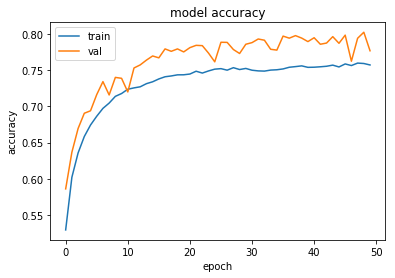

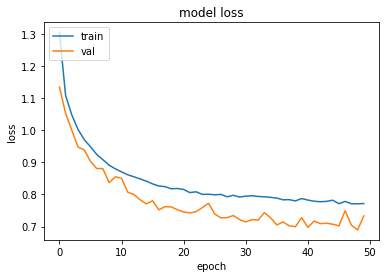

15077/15077 [==============================] - 1s 54us/step
0.7666895894557703 0.7559859388472507
              precision    recall  f1-score   support

           0       0.99      0.76      0.86     11042
           1       0.25      0.70      0.36       263
           2       0.54      0.77      0.63      2647
           3       0.37      0.70      0.49      1125

    accuracy                           0.76     15077
   macro avg       0.54      0.73      0.59     15077
weighted avg       0.86      0.76      0.78     15077

[[8397  286 1464  895]
 [   3  185   39   36]
 [  39  176 2028  404]
 [   1  104  232  788]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.97      0.95      0.96     10996
           1       0.84      0.71      0.77       345
           2       0.82      0.90      0.86      2630
           3       0.77      0.79      0.78      1106

    accuracy                           0.93     15077
   macro avg       0.85      0.84      0.84     15077
weighted avg       0.93      0.93      0.93     15077

[[10468     7   389   132]
 [   33   246    22    44]
 [  160    12  2375    83]
 [   91    29   108   878]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 8s 168us/step - loss: 1.3114 - acc: 0.5213 - val_loss: 1.1324 - val_acc: 0.5936
Epoch 2/50
48000/48000 [==============================] - 8s 160us/step - loss: 1.1136 - acc: 0.5974 - val_loss: 1.0635 - val_acc: 0.6208
Epoch 3/50
48000/48000 [==============================] - 8s 158us/step - loss: 1.0539 - acc: 0.6294 - val_loss: 0.9939 - val_acc:

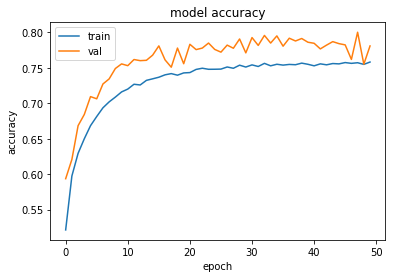

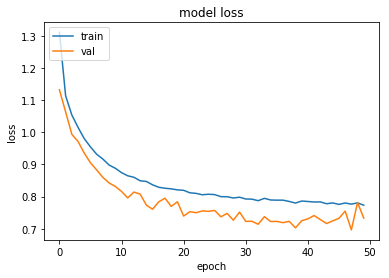

15077/15077 [==============================] - 1s 56us/step
0.6683287267352223 0.7980367447104861
              precision    recall  f1-score   support

           0       0.99      0.83      0.90     10996
           1       0.24      0.87      0.38       345
           2       0.62      0.73      0.67      2630
           3       0.46      0.62      0.53      1106

    accuracy                           0.80     15077
   macro avg       0.58      0.76      0.62     15077
weighted avg       0.87      0.80      0.82     15077

[[9133  433  946  484]
 [   8  299   21   17]
 [  93  322 1912  303]
 [  29  192  197  688]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.97      0.96      0.97     10923
           1       0.80      0.73      0.76       314
           2       0.84      0.92      0.88      2747
           3       0.80      0.78      0.79      1093

    accuracy                           0.93     15077
   macro avg       0.85      0.84      0.85     15077
weighted avg       0.93      0.93      0.93     15077

[[10452     9   349   113]
 [   38   228    23    25]
 [  135    19  2514    79]
 [   97    30   113   853]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 8s 169us/step - loss: 1.2956 - acc: 0.5258 - val_loss: 1.1360 - val_acc: 0.5938
Epoch 2/50
48000/48000 [==============================] - 8s 160us/step - loss: 1.1095 - acc: 0.5985 - val_loss: 1.0579 - val_acc: 0.6415
Epoch 3/50
48000/48000 [==============================] - 8s 162us/step - loss: 1.0520 - acc: 0.6285 - val_loss: 0.9971 - val_acc:

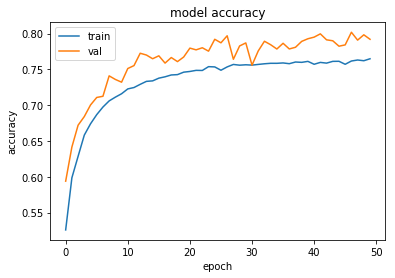

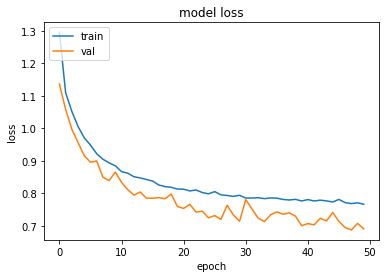

15077/15077 [==============================] - 1s 57us/step
0.6360932787964434 0.8097101545400278
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     10923
           1       0.23      0.89      0.36       314
           2       0.73      0.60      0.66      2747
           3       0.40      0.73      0.52      1093

    accuracy                           0.81     15077
   macro avg       0.59      0.77      0.62     15077
weighted avg       0.88      0.81      0.83     15077

[[9493  395  490  545]
 [   5  280   11   18]
 [ 118  376 1640  613]
 [  25  176   97  795]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.97      0.96      0.96     10931
           1       0.74      0.69      0.72       308
           2       0.83      0.90      0.87      2711
           3       0.79      0.76      0.77      1127

    accuracy                           0.93     15077
   macro avg       0.83      0.83      0.83     15077
weighted avg       0.93      0.93      0.93     15077

[[10458    11   342   120]
 [   27   213    34    34]
 [  163    23  2451    74]
 [  119    39   115   854]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 8s 170us/step - loss: 1.3127 - acc: 0.5144 - val_loss: 1.1293 - val_acc: 0.5960
Epoch 2/50
48000/48000 [==============================] - 8s 159us/step - loss: 1.1219 - acc: 0.5912 - val_loss: 1.0639 - val_acc: 0.6318
Epoch 3/50
48000/48000 [==============================] - 8s 157us/step - loss: 1.0668 - acc: 0.6247 - val_loss: 1.0315 - val_acc:

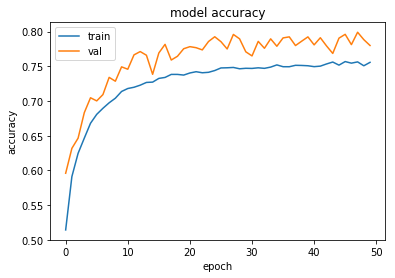

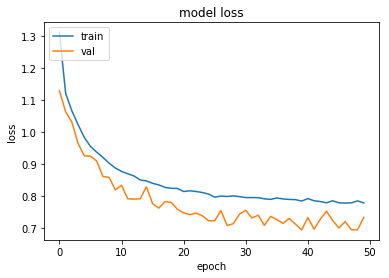

15077/15077 [==============================] - 1s 56us/step
0.7040315351250112 0.7776746037049549
              precision    recall  f1-score   support

           0       0.99      0.80      0.88     10931
           1       0.24      0.81      0.37       308
           2       0.58      0.76      0.65      2711
           3       0.42      0.61      0.50      1127

    accuracy                           0.78     15077
   macro avg       0.56      0.75      0.60     15077
weighted avg       0.86      0.78      0.80     15077

[[8730  383 1237  581]
 [   6  251   26   25]
 [  56  260 2052  343]
 [  23  162  250  692]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.97      0.96      0.97     11002
           1       0.76      0.67      0.71       307
           2       0.84      0.91      0.87      2638
           3       0.80      0.78      0.79      1130

    accuracy                           0.93     15077
   macro avg       0.84      0.83      0.84     15077
weighted avg       0.93      0.93      0.93     15077

[[10533    12   329   128]
 [   36   205    27    39]
 [  141    25  2411    61]
 [  104    27   112   887]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 8s 170us/step - loss: 1.3227 - acc: 0.5128 - val_loss: 1.1298 - val_acc: 0.6048
Epoch 2/50
48000/48000 [==============================] - 7s 155us/step - loss: 1.1221 - acc: 0.5946 - val_loss: 1.0812 - val_acc: 0.6176
Epoch 3/50
48000/48000 [==============================] - 8s 157us/step - loss: 1.0606 - acc: 0.6274 - val_loss: 1.0138 - val_acc:

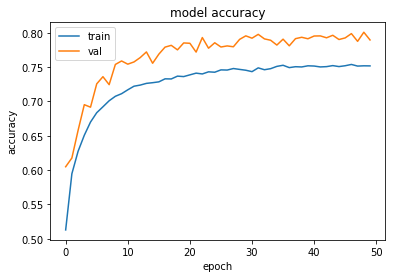

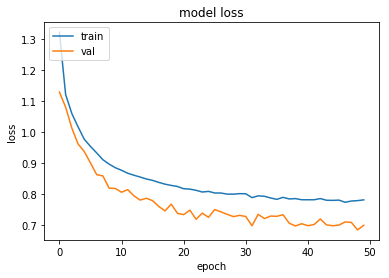

15077/15077 [==============================] - 1s 56us/step
0.651615228590175 0.8061285401644628
              precision    recall  f1-score   support

           0       0.98      0.85      0.91     11002
           1       0.21      0.85      0.34       307
           2       0.65      0.72      0.68      2638
           3       0.48      0.58      0.53      1130

    accuracy                           0.81     15077
   macro avg       0.58      0.75      0.61     15077
weighted avg       0.87      0.81      0.83     15077

[[9338  445  806  413]
 [  10  262   17   18]
 [ 157  317 1901  263]
 [  53  221  203  653]]


In [0]:
# train and test models using cross validation across folds of data
stances = ['unrelated', 'disagree', 'discuss', 'agree']
column_names =  ['Headline', 'Body ID', 'Stance', 'articleBody']
all_data = all_data.sample(frac=1).reset_index(drop=True)
accuracy_scores_rf = []
accuracy_scores_mlp = []
for i in range(5):
  rf = RandomForestClassifier()
  model = build_model(200)
  kFold_train_df = all_data.iloc[0:0]
  kFold_test_df = all_data.iloc[0:0]
  for j in range(4):
    train_fold = dataset_folds(all_data,((i+j)%5)+1,5)
    kFold_train_df = pd.concat([kFold_train_df,train_fold])
  test_fold = dataset_folds(all_data,((i+4)%5)+1,5)
  kFold_test_df = pd.concat([kFold_test_df,test_fold])
  for stance in stances:
    if (len(kFold_train_df[kFold_train_df['Stance'] == str(stance)]) == 0):
      continue;              
    if (len(kFold_train_df[kFold_train_df['Stance'] == str(stance)]) < 15000):
      kFold_train_df = upsample_data(kFold_train_df, str(stance), 15000)
    if (len(kFold_train_df[kFold_train_df['Stance'] == str(stance)]) > 15000):
      kFold_train_df = downsample_data(kFold_train_df, str(stance), 15000)
  Xtrain = data_processing(kFold_train_df, glove_model) #pass in glove model for data processing
  Xtest = data_processing(kFold_test_df, glove_model)
  Ytrain = kFold_train_df.Stance.map({'unrelated': 0, 'disagree': 1, 'discuss': 2, 'agree': 3})
  Ytest = kFold_test_df.Stance.map({'unrelated': 0, 'disagree': 1, 'discuss': 2, 'agree': 3})
  rf = rf.fit(Xtrain, Ytrain)
  Ypred = rf.predict(Xtest)
  rf_score = accuracy_score(Ytest, Ypred)
  accuracy_scores_rf.append(rf_score)
  print(classification_report(Ytest, Ypred))
  print(confusion_matrix(Ytest, Ypred))
  mlp_score = run_MLP(model, Xtrain, Xtest, Ytrain, Ytest, kFold_test_df)
  accuracy_scores_mlp.append(mlp_score)

In [0]:
from statistics import mean 

print(mean(accuracy_scores_rf))
print(mean(accuracy_scores_mlp))